# Data

We will first import our data and use pandas `read_csv()` functionality to convert each .csv file into a pandas datframe.

In [ ]:
import pandas as pd

features = 'https://raw.githubusercontent.com/mkirby1995/Tanzania_water_project/master/train_features.csv'
target = 'https://raw.githubusercontent.com/mkirby1995/Tanzania_water_project/master/train_labels.csv'
test = 'https://raw.githubusercontent.com/mkirby1995/Tanzania_water_project/master/test_features.csv'

features = pd.read_csv(features)
labels = pd.read_csv(target)
X_test = pd.read_csv(test)

In [ ]:
df = features.merge(labels, on = features.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 43 columns):
key_0                    59400 non-null int64
id_x                     59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
pu



---



# Clean

Most data is dirty with missing values, incorect types, etc. Therefore cleaning data should always be part of the data science workflow.

In [ ]:
!pip install category_encoders

In [ ]:
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
import numpy as np



---



We will start our cleaning process by replacing all the 0 values from the construction year column with the arbitrairly selcetd year 1993.

With this cleaned construction year feature we can engineer a pump age and an average pop served per year feature.

In [ ]:
features['construction_year'] = features['construction_year'].replace({0:1993})
features['age'] = features['date_recorded'].astype(str).str[:4].astype(int) - features['construction_year']
features['pop/year'] = features['population'].replace({0:1}) / features['age'].replace({0:1})

In [ ]:
X_test['construction_year'] = X_test['construction_year'].replace({0:1993})
X_test['age'] = X_test['date_recorded'].astype(str).str[:4].astype(int) - X_test['construction_year']
X_test['pop/year'] = X_test['population'].replace({0:1}) / X_test['age'].replace({0:1})



---



Feature engineering is one of the craftiest weapons in the data scienctists arsenal,

In [ ]:
features['water_/_person'] = features['amount_tsh'].replace({0:1}) / features['population'].replace({0:1})

In [ ]:
X_test['water_/_person'] = X_test['amount_tsh'].replace({0:1}) / X_test['population'].replace({0:1})

We will write a function to help us chect the cardinality of each feature (how many unique values there are in each feature)

In [ ]:
def reverse_cardinality_check(n, df):
  """
  Given a cardinality limit (n) and a dataframe this function will search the
  dataframe for features above the cardinality limit, then create a dict
  from the results
  """

  feature_list = []

  cardinality_value = []

  for _ in range(len(df.columns)):
    if len(df[df.columns[_]].value_counts()) > n:

      feature_list.append(df.columns[_])

      cardinality_value.append(len(df[df.columns[_]].value_counts()))


  feature_dict = dict(zip(feature_list, cardinality_value))

  return feature_dict



---



Here we can see our high cardinality features

In [ ]:
high_cardinality_feature_dict = reverse_cardinality_check(150, features)
high_cardinality_feature_dict

{'date_recorded': 356,
 'funder': 1897,
 'gps_height': 2428,
 'id': 59400,
 'installer': 2145,
 'latitude': 57517,
 'longitude': 57516,
 'pop/year': 4421,
 'population': 1049,
 'scheme_name': 2696,
 'subvillage': 19287,
 'ward': 2092,
 'water_/_person': 2633,
 'wpt_name': 37400}

We can create a dataframe from our low cardinality features

In [ ]:
low_cardinality_features = features.drop(columns = list(high_cardinality_feature_dict.keys()))
low_cardinality_features.columns

Index(['amount_tsh', 'num_private', 'basin', 'region', 'region_code',
       'district_code', 'lga', 'public_meeting', 'recorded_by',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'age'],
      dtype='object')

And another from our high cardinality features

In [ ]:
high_cardinality_features = features[list(high_cardinality_feature_dict.keys())]
high_cardinality_features.columns

Index(['id', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'subvillage', 'ward', 'population',
       'scheme_name', 'pop/year', 'water_/_person'],
      dtype='object')

Then encode each dataframe

In [ ]:
one_hot_encode = ce.OneHotEncoder(use_cat_names=True)
one_hot_encode.fit(low_cardinality_features, labels['status_group'])
low_cardinality_features = one_hot_encode.transform(low_cardinality_features)

ordinal_encode = ce.OrdinalEncoder()
ordinal_encode.fit(high_cardinality_features, labels['status_group'])
high_cardinality_features = ordinal_encode.transform(high_cardinality_features)

Then merge the two back together

In [ ]:
features = low_cardinality_features.merge(high_cardinality_features,
                                          on = low_cardinality_features.index)

In [ ]:
feature_names = features.columns
feature_names

Index(['key_0', 'amount_tsh', 'num_private', 'basin_Lake Nyasa',
       'basin_Lake Victoria', 'basin_Pangani', 'basin_Ruvuma / Southern Coast',
       'basin_Internal', 'basin_Lake Tanganyika', 'basin_Wami / Ruvu',
       ...
       'installer', 'longitude', 'latitude', 'wpt_name', 'subvillage', 'ward',
       'population', 'scheme_name', 'pop/year', 'water_/_person'],
      dtype='object', length=322)

Next we can impute and scale our features

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(features, labels['status_group'])
features = imputer.transform(features)

In [ ]:
scaler = RobustScaler()
scaler.fit(features, labels['status_group'])
features = scaler.transform(features)

We can then do this for our target dataframe as well

In [ ]:
high_cardinality_X_test_dict = reverse_cardinality_check(150, X_test)
high_cardinality_X_test_dict

In [ ]:
low_cardinality_X_test = X_test.drop(columns = list(high_cardinality_X_test_dict.keys()))
low_cardinality_X_test.columns

In [ ]:
high_cardinality_X_test = X_test[list(high_cardinality_X_test_dict.keys())]
high_cardinality_X_test.columns

In [ ]:
low_cardinality_X_test = one_hot_encode.transform(low_cardinality_X_test)

In [ ]:
high_cardinality_X_test = ordinal_encode.transform(high_cardinality_X_test)

In [ ]:
X_test = low_cardinality_X_test.merge(high_cardinality_X_test,
                                          on = low_cardinality_X_test.index)

In [ ]:
X_test = imputer.transform(X_test)

In [ ]:
X_test = scaler.transform(X_test)

# Visualize

In [ ]:
!pip install geopandas

     |████████████████████████████████| 901kB 4.9MB/s 
     |████████████████████████████████| 11.2MB 30.0MB/s 
     |████████████████████████████████| 17.9MB 29.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 30, 20

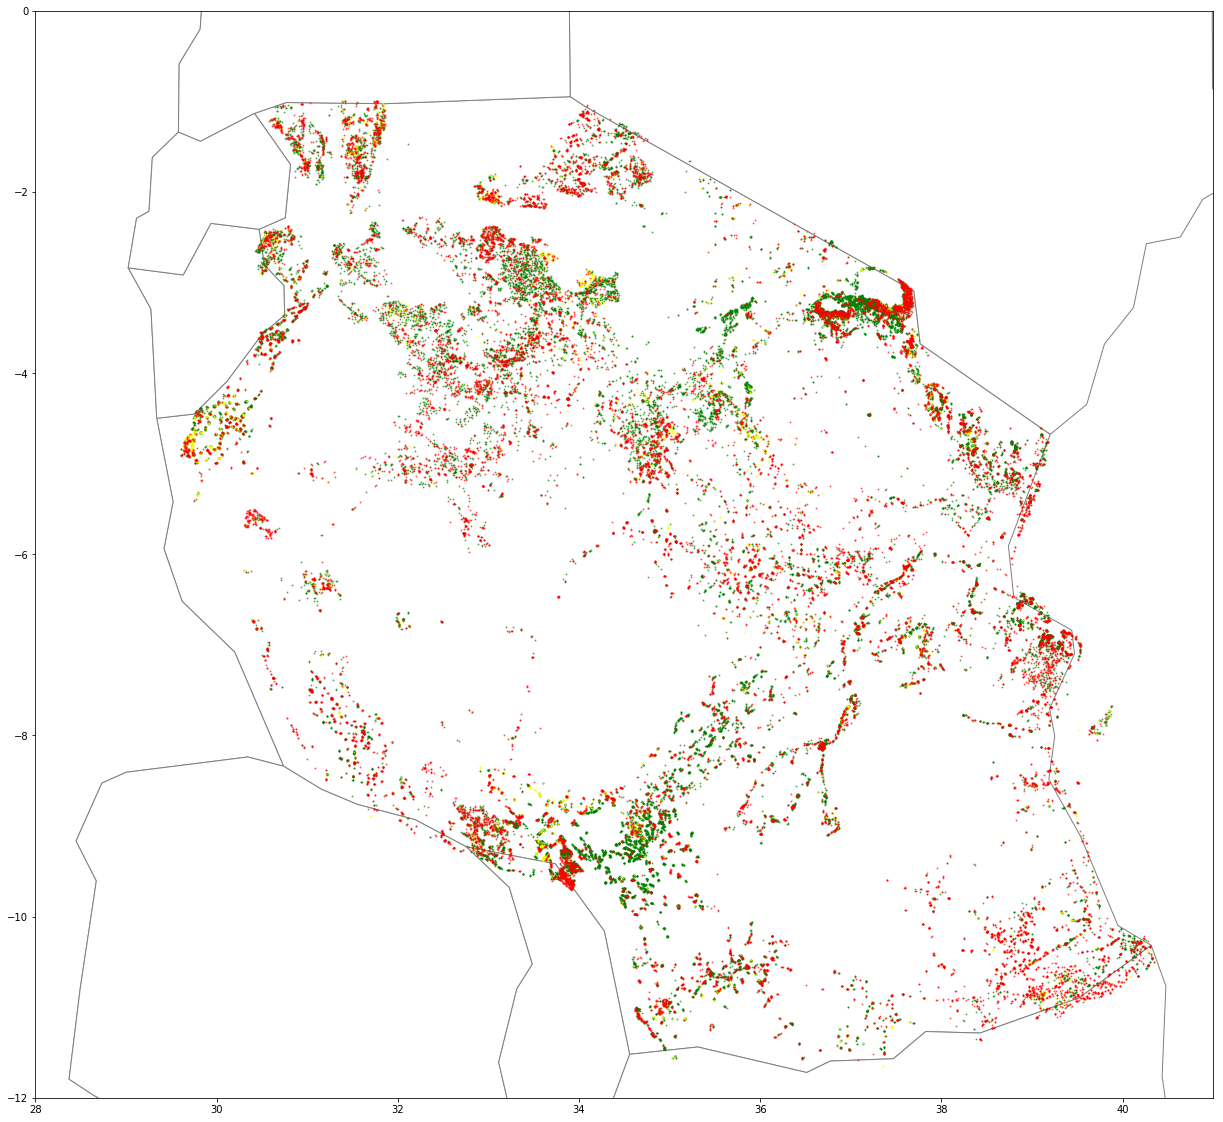

In [ ]:
import geopandas

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))

functional = gdf.where(gdf['status_group'] == 'functional')
repair = gdf.where(gdf['status_group'] == 'functional needs repair')
broken = gdf.where(gdf['status_group'] == 'non functional')

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to Africa
ax = world[world.continent == 'Africa'].plot(
    color='white', edgecolor='gray')

ax.scatter(functional['longitude'], functional['latitude'],
           c='green',alpha=.5, s=1)

ax.scatter(repair['longitude'], repair['latitude'],
           c='yellow', alpha=.5, s=1)

ax.scatter(broken['longitude'], broken['latitude'],
           c='red', alpha=.5, s=1)

plt.ylim(-12, 0)
plt.xlim(28,41)

plt.show()



---



# Model

Baseline model

In [ ]:
X_matrix, y_vector = features, labels['status_group']

In [ ]:
majority_class = y_vector.mode()
y_vector.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [ ]:
from sklearn.metrics import accuracy_score
majority_prediction = [majority_class] * len(y_vector)
accuracy_score(y_vector, majority_prediction)

0.543080808080808

Overfit

In [ ]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_depth=50)
decision_tree.fit(X_matrix, y_vector)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def con_matrix_analysis(model):
  x = model.predict(features)
  y = y_vector

  print(classification_report(y, x,
        target_names=['Functional', 'Needs Repair', 'Not-Functional']))

  con_matrix = pd.DataFrame(confusion_matrix(y, x),
             columns=['Predicted Functional', 'Predicted Needs Repair', 'Predicted Not-Functional'],
             index=['Actual Functional', 'Actual Needs Repair', 'Actual Not-Functional'])

  sns.heatmap(data=con_matrix, cmap='cool')
  plt.show();
  return con_matrix

In [ ]:
rcParams['figure.figsize'] = 15, 10

                precision    recall  f1-score   support

    Functional       1.00      1.00      1.00     32259
  Needs Repair       1.00      1.00      1.00      4317
Not-Functional       1.00      1.00      1.00     22824

      accuracy                           1.00     59400
     macro avg       1.00      1.00      1.00     59400
  weighted avg       1.00      1.00      1.00     59400



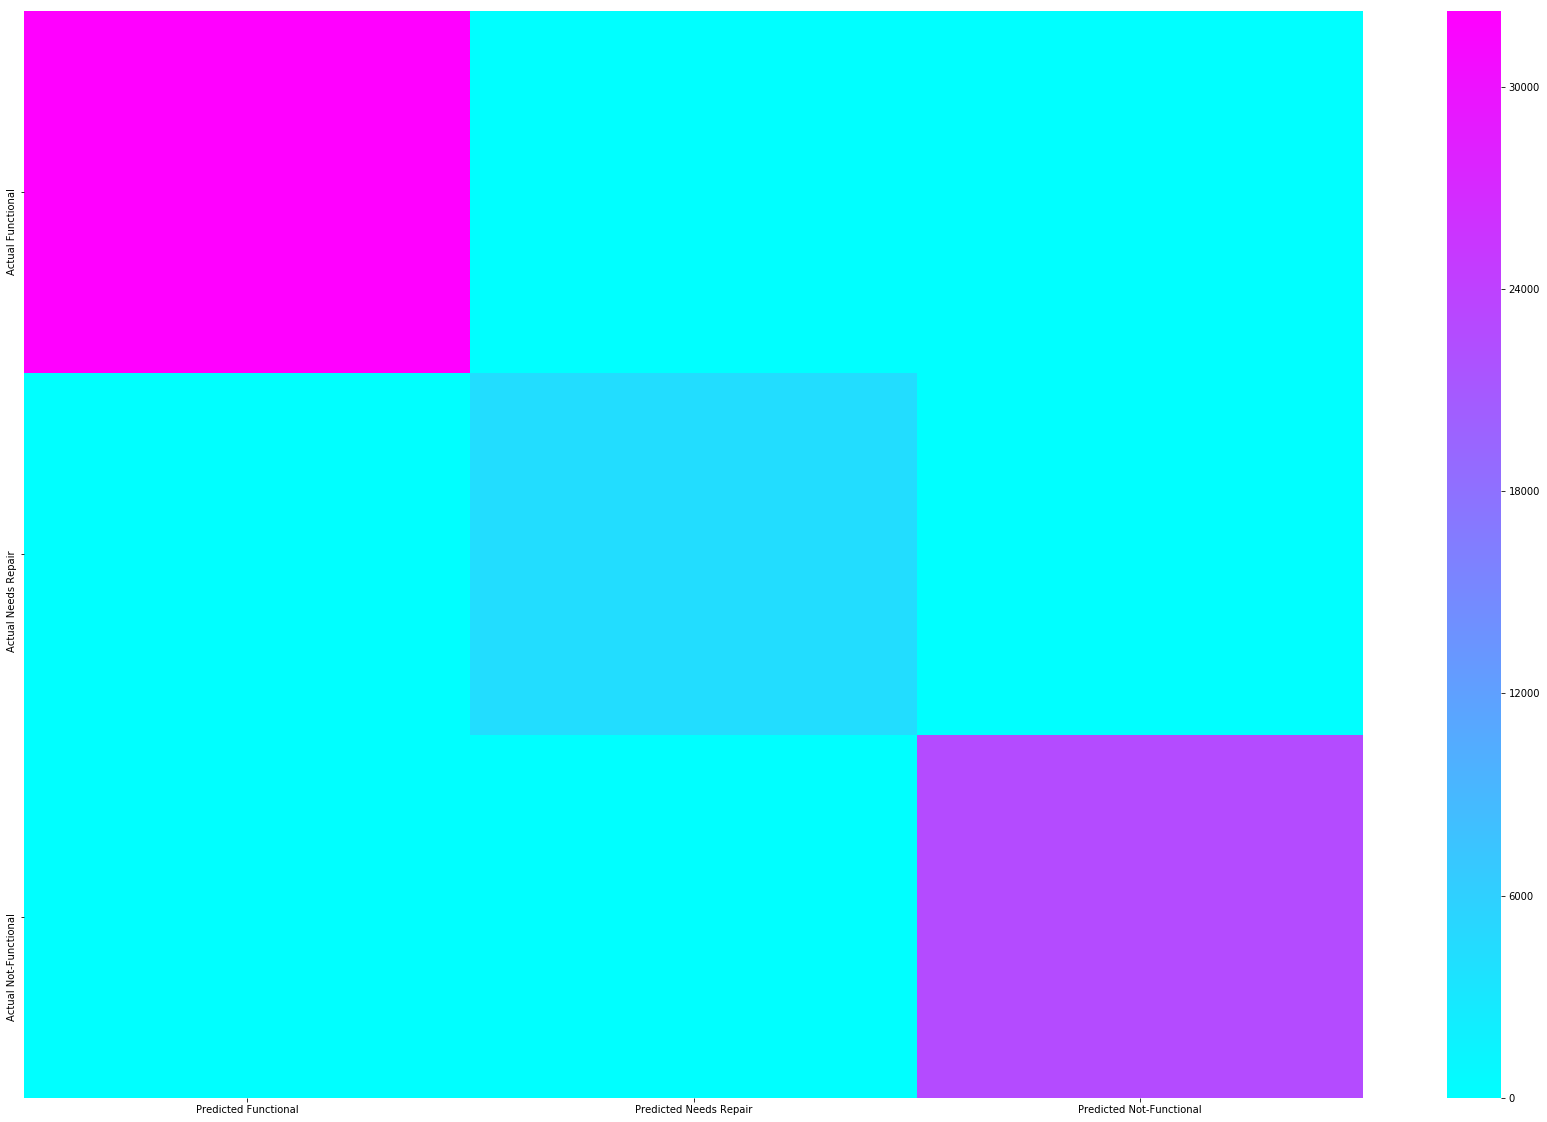

,Predicted Functional,Predicted Needs Repair,Predicted Not-Functional
Actual Functional,32259,0,0
Actual Needs Repair,15,4302,0
Actual Not-Functional,15,1,22808


In [ ]:
con_matrix_analysis(decision_tree)

# Model Analysis

## Cross Validation

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'max_depth': [25, 26, 27, 28, 29]
}

gridsearch = RandomizedSearchCV(
    RandomForestClassifier(n_estimators=92, n_jobs=-1, random_state=42),
    param_distributions=param_distributions,
    n_iter=5,
    cv=5,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

gridsearch.fit(X_matrix, y_vector)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.1min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  6.7min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=92, n_jobs=-1,
                                                    oob_

In [ ]:
results = pd.DataFrame(gridsearch.cv_results_)
print(f'Best result from search of {len(results)} parameter combinations')
results.sort_values(by='rank_test_score').head(5)

Best result from search of 5 parameter combinations


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,27.167043,0.825303,0.787051,0.006621,26,{'max_depth': 26},0.815840,0.810959,0.814815,0.810690,0.808133,0.812088,0.002842,1,0.982786,0.982112,0.978725,0.980661,0.982198,0.981296,0.001464
3,28.378227,0.460699,0.804755,0.040848,28,{'max_depth': 28},0.814241,0.809275,0.812879,0.812037,0.809396,0.811566,0.001952,2,0.990951,0.990930,0.989794,0.990215,0.991520,0.990682,0.000607
0,27.618210,0.679882,0.692960,0.048485,25,{'max_depth': 25},0.814662,0.809023,0.812542,0.810269,0.809901,0.811279,0.002052,3,0.973695,0.974684,0.973927,0.974853,0.975864,0.974604,0.000767
2,28.065350,0.376285,0.788129,0.004013,27,{'max_depth': 27},0.816177,0.810285,0.813889,0.808586,0.807375,0.811263,0.003295,4,0.985879,0.988005,0.983502,0.986595,0.987206,0.986237,0.001536
4,26.425743,4.438918,0.774959,0.180058,29,{'max_depth': 29},0.815420,0.809275,0.813552,0.811027,0.806112,0.811077,0.003252,5,0.993329,0.993834,0.992782,0.993855,0.993792,0.993519,0.000416


In [ ]:
model = gridsearch.best_estimator_

                precision    recall  f1-score   support

    Functional       0.96      1.00      0.98     32259
  Needs Repair       1.00      0.88      0.94      4317
Not-Functional       1.00      0.97      0.98     22824

      accuracy                           0.98     59400
     macro avg       0.99      0.95      0.97     59400
  weighted avg       0.98      0.98      0.98     59400



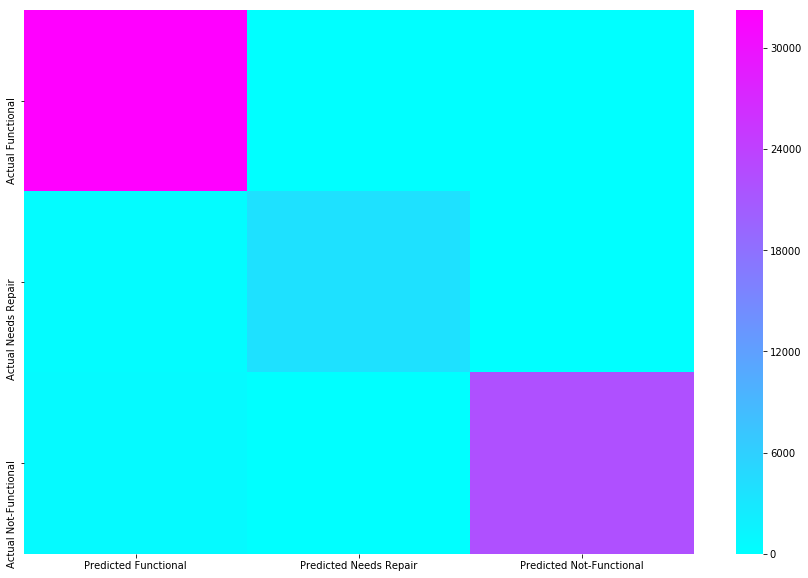

,Predicted Functional,Predicted Needs Repair,Predicted Not-Functional
Actual Functional,32224,0,35
Actual Needs Repair,463,3820,34
Actual Not-Functional,741,1,22082


In [ ]:
con_matrix_analysis(model)

# Export

In [ ]:
# estimator is your model or pipeline, which you've fit on X_train

# X_test is your pandas dataframe or numpy array,
# with the same number of rows, in the same order, as test_features.csv,
# and the same number of columns, in the same order, as X_train

y_pred = model.predict(X_test)


# Makes a dataframe with two columns, id and status_group,
# and writes to a csv file, without the index

sample_submission = pd.read_csv('https://raw.githubusercontent.com/mkirby1995/Tanzania_water_project/master/sample_submission.csv')
submission = sample_submission.copy()


In [ ]:
submission.shape, y_pred.shape

In [ ]:
submission['status_group'] = y_pred
submission.to_csv('submission_1.csv', index=False)

In [ ]:
from google.colab import files
files.download('submission_1.csv')